# **SpecAugment_ A Simple Data Augmentation Method for Automatic Speech Recognition**

Park, D. S., Chan, W., Zhang, Y., Chiu, C. C., Zoph, B., Cubuk, E. D., & Le, Q. V. (2019). Specaugment: A simple data augmentation method for automatic speech recognition. arXiv preprint arXiv:1904.08779.

## **Default Setting**

In [3]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 686kB 4.0MB/s 


In [44]:
import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np
import os

from matplotlib import pyplot as plt
from pathlib import Path

print("[VERSION]")
print(f"tensorflow       : {tf.__version__}")
print(f"tensorflow addons: {tfa.__version__}")

[VERSION]
tensorflow       : 2.5.0
tensorflow addons: 0.13.0


In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [30]:
class HParams(object):
    def __init__(self):
        self.mapping_dict = None

        ## Dataset.
        self.n_cpus = len(tf.config.list_physical_devices("CPU"))
        self.n_gpus = len(tf.config.list_physical_devices("GPU")) ## torch.cuda.device_count()

        self.per_replica_batch_size = 32
        self.global_batch_size = self.per_replica_batch_size * (self.n_gpus if self.n_gpus else self.n_cpus)

        self.auto = tf.data.AUTOTUNE

        self.slice_length = 8000

        ## Mel-Spectrogram.
        self.sample_rate    = 8_000
        self.sample_rate_ms = 8
        self.frame_length   = 25 * self.sample_rate_ms
        self.frame_step     = 10 * self.sample_rate_ms
        self.fft_length     = 512
        self.window_fn      = tf.signal.hamming_window
        self.pad_end        = True
        
        self.num_mel_bins = 64
        self.num_spectrogram_bins = self.fft_length // 2 + 1
        self.lower_edge_hertz = 0.
        self.upper_edge_hertz = 4_000.


HPARAMS = HParams()

## **Dataset**

### **Load Dataset**

In [7]:
data_dir = Path("data/mini_speech_commands")
if not data_dir.exists():
    tf.keras.utils.get_file(
        "mini_speech_commands.zip",
        origin = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract = True,
        cache_dir = ".", 
        cache_subdir = "data")

182083584/182082353 [==============================] - 1s 0us/step


In [8]:
tmp = np.array(sorted(list(data_dir.glob("down/*.wav"))))
tmp[:5]

array([PosixPath('data/mini_speech_commands/down/004ae714_nohash_0.wav'),
       PosixPath('data/mini_speech_commands/down/00b01445_nohash_1.wav'),
       PosixPath('data/mini_speech_commands/down/00f0204f_nohash_0.wav'),
       PosixPath('data/mini_speech_commands/down/0132a06d_nohash_1.wav'),
       PosixPath('data/mini_speech_commands/down/0132a06d_nohash_4.wav')],
      dtype=object)

### **Build Dataset Pipelines**

In [31]:
commands = [i.parts[-2] for i in list(data_dir.glob("*/*.wav"))]
commands = np.array(sorted(list(set(commands))))
mapping_dict = {j:i for i, j in enumerate(commands)}

HPARAMS.mapping_dict = mapping_dict

mapping_dict

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'right': 4,
 'stop': 5,
 'up': 6,
 'yes': 7}

In [32]:
def generator():
    audio_path = tf.io.gfile.glob(f"{str(data_dir)}/*/*.wav")
    
    for p in audio_path:
        if not isinstance(p, str):
            p = str(p)

        audio_string = tf.io.read_file(p)
        audio        = tf.audio.decode_wav(audio_string).audio[:, 0]

        audio_shape  = audio.shape[0]
        label        = mapping_dict[p.split(os.path.sep)[-2]]

        yield audio, audio_shape, label

In [33]:
prng = tf.random.Generator.from_non_deterministic_state()

@tf.function
def _random_slice(audio, length, label):
    sp = prng.uniform(
        shape = [],
        minval = 0, 
        maxval = length - HPARAMS.slice_length, 
        dtype = tf.int64)
    
    return audio[sp:sp + HPARAMS.slice_length], label

In [34]:
ds = tf.data.Dataset.from_generator(
    generator,
    output_signature = (
        tf.TensorSpec(shape = (None,), dtype = tf.float32),
        tf.TensorSpec(shape = (), dtype = tf.int64),
        tf.TensorSpec(shape = (), dtype = tf.int64),))

ds = (
    ds.map(_random_slice, num_parallel_calls = HPARAMS.auto)
    .cache()
    .batch(HPARAMS.global_batch_size, num_parallel_calls = HPARAMS.auto)
    .prefetch(HPARAMS.auto))

ds.element_spec

(TensorSpec(shape=(None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [35]:
for element in ds.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(32, 8000) (32,)


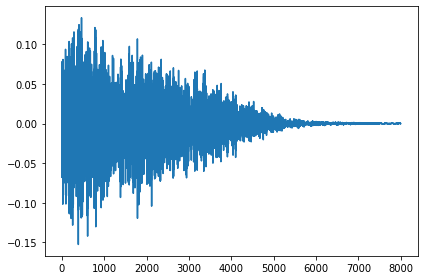

In [36]:
plt.plot(foo[0])

plt.tight_layout()
plt.show()

## **Modeling**

### **Preprocessing**

In [37]:
class Preprocessing(tf.keras.Model):
    
    def __init__(
        self, 
        frame_length = HPARAMS.frame_length, 
        frame_step   = HPARAMS.frame_step,
        fft_length   = HPARAMS.fft_length,
        window_fn    = HPARAMS.window_fn,
        pad_end      = HPARAMS.pad_end,
        num_mel_bins = HPARAMS.num_mel_bins, 
        num_spectrogram_bins = HPARAMS.num_spectrogram_bins, 
        sample_rate = HPARAMS.sample_rate, 
        lower_edge_hertz = HPARAMS.lower_edge_hertz,
        upper_edge_hertz = HPARAMS.upper_edge_hertz,
        **kwargs
    ):
        super(Preprocessing, self).__init__(self, **kwargs)
        
        ## STFT parameters.
        self.frame_length = frame_length
        self.frame_step   = frame_step
        self.fft_length   = fft_length
        self.window_fn    = window_fn
        self.pad_end      = pad_end
        
        ## Mel-spectrogram parameters.
        self.num_mel_bins = num_mel_bins
        self.num_spectrogram_bins = num_spectrogram_bins
        self.sample_rate = sample_rate
        self.lower_edge_hertz = lower_edge_hertz
        self.upper_edge_hertz = upper_edge_hertz
        
        ## Instance normalization layer.
        self.norm_layer = tfa.layers.InstanceNormalization()


    @tf.function        
    def _mel_spectrogram(self, x):
        stfts = tf.signal.stft(
            x, 
            frame_length = self.frame_length, 
            frame_step   = self.frame_step,
            fft_length   = self.fft_length,
            window_fn    = self.window_fn,
            pad_end      = self.pad_end,
        )

        spectrograms = tf.abs(stfts)

        mel_spectrograms = tf.tensordot(
            spectrograms, 
            tf.signal.linear_to_mel_weight_matrix(
                num_mel_bins = self.num_mel_bins, 
                num_spectrogram_bins = self.num_spectrogram_bins, 
                sample_rate = self.sample_rate, 
                lower_edge_hertz = self.lower_edge_hertz,
                upper_edge_hertz = self.upper_edge_hertz,
            ),
            1,
        )

        return mel_spectrograms
    

    @tf.function
    def _instance_normalization(self, x, training = None):
        return self.norm_layer(x, training = training)
    
    
    @tf.function
    def call(self, x, training = None):
        x = self._mel_spectrogram(x)
        x = self._instance_normalization(x, training = training)
        return x

### **Augmentation**

In [46]:
class SpecAugment(tf.keras.Model):
    
    def __init__(
        self, 
        min_fac = 0.05,
        max_fac = 0.2,
        **kwargs,
    ):
        super(SpecAugment, self).__init__(**kwargs)
        
        self.prng = tf.random.Generator.from_non_deterministic_state()
        self.image_size = [HPARAMS.slice_length // HPARAMS.frame_step, HPARAMS.num_mel_bins]
        
        self.min_fac = min_fac
        self.max_fac = max_fac
        
        self.freq_masking_size = [int(self.image_size[1] * self.min_fac), ## min
                                  int(self.image_size[1] * self.max_fac)] ## max
        self.time_masking_size = [int(self.image_size[0] * self.min_fac), ## min
                                  int(self.image_size[0] * self.max_fac)] ## max
        
        self.flow_stddev_size = [0.1, 1.0]
        

    @tf.function(input_signature = [tf.TensorSpec(
        shape = [HPARAMS.per_replica_batch_size,## != global batch size
                 HPARAMS.slice_length // HPARAMS.frame_step, 
                 HPARAMS.num_mel_bins,
                 1], 
        dtype = tf.float32)])
    def _time_warpping(self, x):
        flow_stddev = prng.uniform(shape = [], 
                                   minval = self.flow_stddev_size[0], 
                                   maxval = self.flow_stddev_size[1],
                                   dtype = tf.float32)
        
        flow = prng.normal(shape = [*x.shape[:-1], 2], stddev = flow_stddev)
        
        x = tfa.image.dense_image_warp(x, flow)
        
        return x

    
    @tf.function
    def _freq_masking(self, x):
        width = prng.uniform([], *self.freq_masking_size, dtype = tf.int32)
        
        sp = prng.uniform(shape = [],
                          minval = 0, 
                          maxval = self.image_size[1] - width, 
                          dtype = tf.int32)
                
        x = tfa.image.cutout(x, 
                             mask_size = (self.image_size[0] * 2, width * 2), ## ???
                             offset = (0, sp))
        
        return x
    
    
    @tf.function
    def _time_masking(self, x):
        height = prng.uniform([], *self.time_masking_size, dtype = tf.int32)
        
        sp = prng.uniform(shape = [],
                          minval = 0, 
                          maxval = self.image_size[0] - height, 
                          dtype = tf.int32)
        
        x = tfa.image.cutout(x, 
                             mask_size = (height * 2, self.image_size[1] * 2), ## ???
                             offset = (sp, 0))
        
        return x    
    
    
    @tf.function
    def call(self, x, training = None):
        if training:
            x = self._time_warpping(x)
            x = self._freq_masking(x)
            x = self._time_masking(x)
        
        return x

### **Body**

In [50]:
class MyModel(tf.keras.Model):

    def __init__(
        self, 
        **kwargs,
    ):
        super(MyModel, self).__init__(**kwargs)

        self.preprocessing_model = Preprocessing()
        self.augmentation_model = SpecAugment()


    @tf.function
    def call(self, x, training = None):
        x = self.preprocessing_model(x, training = training)
        x = tf.expand_dims(x, axis = -1)

        x = self.augmentation_model(x, training = training)

        ## Now, enter your own model here.

        return x

## **Show Examples**

In [66]:
model = MyModel()

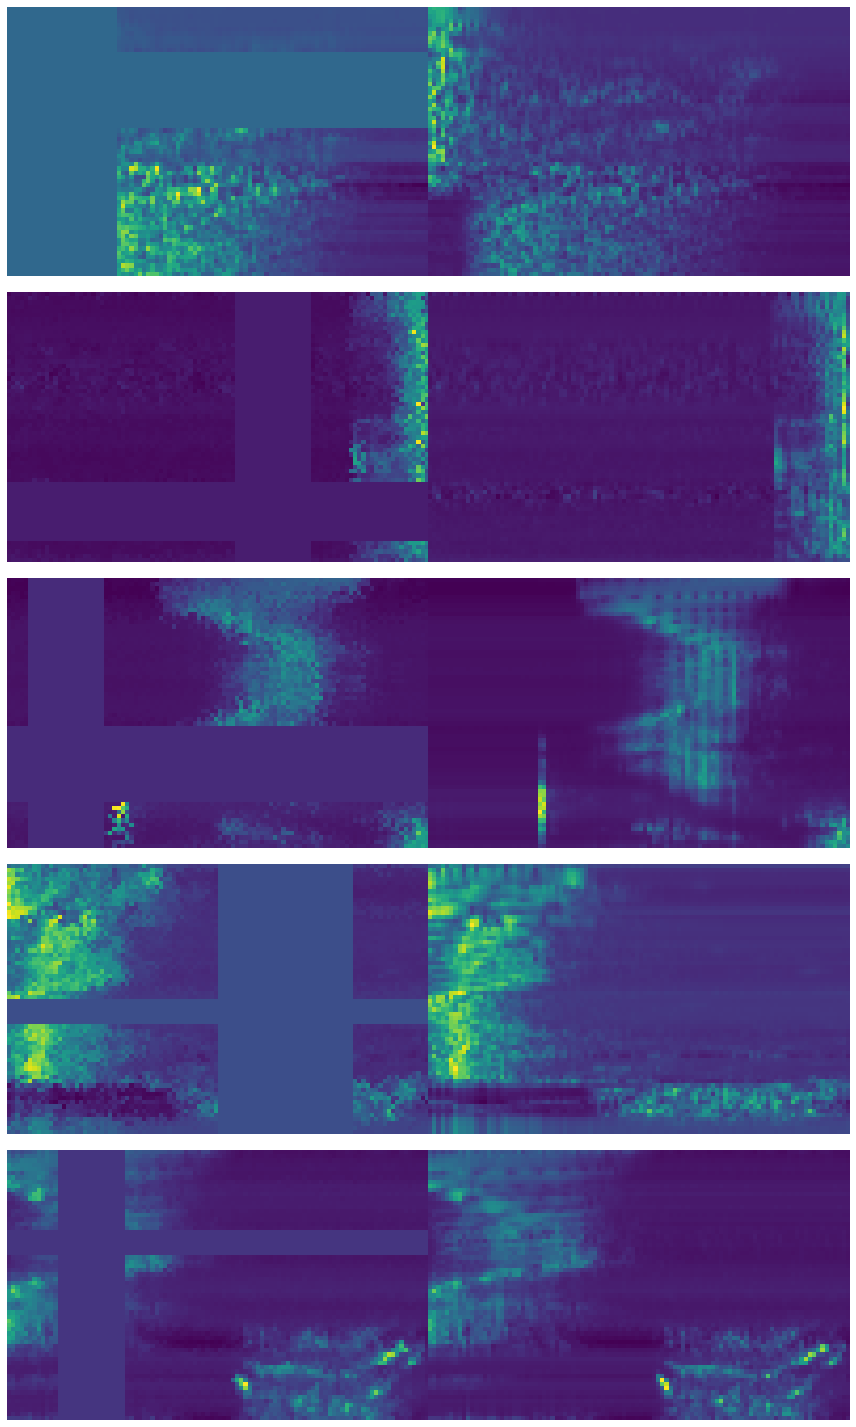

In [67]:
n_sample = 5

plt.figure(figsize = (12, 4 * n_sample), facecolor = "white")

for i, element in enumerate(ds.take(n_sample)):
    foo, bar = element

    augment     = model(foo, training = True)
    non_augment = model(foo, training = False)

    plt.subplot(n_sample, 2, 2 * i + 1)
    plt.imshow(tf.transpose(augment[i, ..., 0], perm = [1, 0]))
    plt.axis("off")

    plt.subplot(n_sample, 2, 2 * i + 2)
    plt.imshow(tf.transpose(non_augment[i, ..., 0], perm = [1, 0]))
    plt.axis("off")

plt.tight_layout()
plt.show()